# Assignment 2: Bias in data

## Getting article quality predictions

In [2]:
import csv
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# getting the article data from the CSV files
headers = {'User-Agent' : 'https://github.com/jingyany', 'From' : 'jingyany@uw.edu'}

data = []
with open('page_data.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append([row[0],row[1],row[2]])
del data[0]

In [4]:
# Get the predicted quality scores for each article from ORES
def get_data(revision_ids, headers):
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return response

In [5]:
# Get the article quality for each article from ORES
def get_prediction(id_lst, headers):
    res = []
    start = 0
    while start < len(id_lst):
        end = min(start + 100, len(id_lst))
        score = get_data(id_lst[start : end], headers)
        for rev_id in score['enwiki']['scores']:
            if 'score' in score['enwiki']['scores'][rev_id]['wp10']:
                res.append(score['enwiki']['scores'][rev_id]['wp10']['score']['prediction'])
            else:
                res.append(None)
        start = start + 100
    return res

In [6]:
id_lst = [item[2] for item in data]
len(id_lst)

47197

In [7]:
prediction = get_prediction(id_lst, headers)

In [8]:
len(prediction)

47197

## Combine the datasets

In [9]:
# Read article data to pandas from csv file
df = pd.read_csv('page_data.csv')
df.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [10]:
# Add article quality to the dataset
pred = pd.Series(prediction)
df['article_quality'] = pred.values

In [11]:
df.head()

,page,country,rev_id,article_quality
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub
1,Bir I of Kanem,Chad,355319463,Stub
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046,Stub
3,Template:Uganda-politician-stub,Uganda,391862070,Stub
4,Template:Namibia-politician-stub,Namibia,391862409,Stub


In [12]:
# Read population data to pandas from csv file
df2 = pd.read_csv('Population Mid-2015.csv')
df2.head()

,country,Location Type,TimeFrame,Data Type,Data
0,Afghanistan,Country,Mid-2015,Number,"32,247,000"
1,Albania,Country,Mid-2015,Number,"2,892,000"
2,Algeria,Country,Mid-2015,Number,"39,948,000"
3,Andorra,Country,Mid-2015,Number,"78,000"
4,Angola,Country,Mid-2015,Number,"25,000,000"


In [13]:
# Merge article data and population data based on country
new_df = pd.merge(df, df2, on='country', how='inner')
new_df.head()

,page,country,rev_id,article_quality,Location Type,TimeFrame,Data Type,Data
0,Template:ZambiaProvincialMinisters,Zambia,235107991,Stub,Country,Mid-2015,Number,"15,473,900"
1,Gladys Lundwe,Zambia,757566606,Stub,Country,Mid-2015,Number,"15,473,900"
2,Mwamba Luchembe,Zambia,764848643,Stub,Country,Mid-2015,Number,"15,473,900"
3,Thandiwe Banda,Zambia,768166426,Start,Country,Mid-2015,Number,"15,473,900"
4,Sylvester Chisembele,Zambia,776082926,C,Country,Mid-2015,Number,"15,473,900"


In [14]:
# Generate final dataset for the data analysis
final = pd.DataFrame({'country' : new_df.country,
                      'article_name' : new_df.page,
                     'revision_id': new_df.rev_id,
                     'article_quality': new_df.article_quality,
                     'population': new_df.Data})
final.head()

,article_name,article_quality,country,population,revision_id
0,Template:ZambiaProvincialMinisters,Stub,Zambia,"15,473,900",235107991
1,Gladys Lundwe,Stub,Zambia,"15,473,900",757566606
2,Mwamba Luchembe,Stub,Zambia,"15,473,900",764848643
3,Thandiwe Banda,Start,Zambia,"15,473,900",768166426
4,Sylvester Chisembele,C,Zambia,"15,473,900",776082926


In [15]:
# Save the final dataset to a csv file
final.to_csv('final_data.csv')

## Analysis

### Calculate the propertion of articles per population

In [16]:
# Calculate the total number of articles of each country
article_per_country = final[['article_name','country']].groupby(['country']).agg(['count'])
article_per_country = article_per_country.reset_index()
article_per_country.columns = article_per_country.columns.get_level_values(0)
article_per_country.head()

,country,article_name
0,Afghanistan,327
1,Albania,460
2,Algeria,119
3,Andorra,34
4,Angola,110


In [17]:
temp = pd.merge(article_per_country, df2, on='country', how='inner' )
temp.head()

,country,article_name,Location Type,TimeFrame,Data Type,Data
0,Afghanistan,327,Country,Mid-2015,Number,"32,247,000"
1,Albania,460,Country,Mid-2015,Number,"2,892,000"
2,Algeria,119,Country,Mid-2015,Number,"39,948,000"
3,Andorra,34,Country,Mid-2015,Number,"78,000"
4,Angola,110,Country,Mid-2015,Number,"25,000,000"


In [18]:
temp['Data'] = temp['Data'].str.replace(',', '')
temp['Data'] = temp['Data'].astype(int)
temp.dtypes

country          object
article_name      int64
Location Type    object
TimeFrame        object
Data Type        object
Data              int64
dtype: object

In [19]:
# Calculate articles per population
temp['articles_per_popilation'] = temp.article_name/temp.Data
temp.head()

,country,article_name,Location Type,TimeFrame,Data Type,Data,articles_per_popilation
0,Afghanistan,327,Country,Mid-2015,Number,32247000,0.000010
1,Albania,460,Country,Mid-2015,Number,2892000,0.000159
2,Algeria,119,Country,Mid-2015,Number,39948000,0.000003
3,Andorra,34,Country,Mid-2015,Number,78000,0.000436
4,Angola,110,Country,Mid-2015,Number,25000000,0.000004


### Calculate the percentage of high-quality articles for each country

In [20]:
# Select articles with high quality
temp2 = final[(final['article_quality'] == 'FA') | (final['article_quality'] == 'GA')]
temp2.head()

,article_name,article_quality,country,population,revision_id
89,Mahamat Nouri,FA,Chad,"13,707,000",792954115
112,Hissène Habré,GA,Chad,"13,707,000",803166806
288,Robert Mugabe,FA,Zimbabwe,"17,354,000",806814411
291,Grace Mugabe,GA,Zimbabwe,"17,354,000",807337237
451,Robert Kyagulanyi Ssentamu,GA,Uganda,"40,141,000",802822017


In [21]:
# Count number of high-quality articles per country
highquality_per_country = temp2[['article_name','country']].groupby(['country']).agg(['count'])
highquality_per_country = highquality_per_country.reset_index()
highquality_per_country.columns = highquality_per_country.columns.get_level_values(0)
highquality_per_country.head()

,country,article_name
0,Afghanistan,19
1,Albania,5
2,Algeria,3
3,Angola,2
4,Argentina,16


In [22]:
temp = pd.merge(highquality_per_country, temp, on='country', how='outer' )
temp.head()

,country,article_name_x,article_name_y,Location Type,TimeFrame,Data Type,Data,articles_per_popilation
0,Afghanistan,19.0,327,Country,Mid-2015,Number,32247000,0.000010
1,Albania,5.0,460,Country,Mid-2015,Number,2892000,0.000159
2,Algeria,3.0,119,Country,Mid-2015,Number,39948000,0.000003
3,Angola,2.0,110,Country,Mid-2015,Number,25000000,0.000004
4,Argentina,16.0,496,Country,Mid-2015,Number,42426000,0.000012


In [23]:
# Calculate the percentage of high-quality articles per country
temp['high_quality_articles'] = temp.article_name_x/temp.article_name_y
temp.head()

,country,article_name_x,article_name_y,Location Type,TimeFrame,Data Type,Data,articles_per_popilation,high_quality_articles
0,Afghanistan,19.0,327,Country,Mid-2015,Number,32247000,0.000010,0.058104
1,Albania,5.0,460,Country,Mid-2015,Number,2892000,0.000159,0.010870
2,Algeria,3.0,119,Country,Mid-2015,Number,39948000,0.000003,0.025210
3,Angola,2.0,110,Country,Mid-2015,Number,25000000,0.000004,0.018182
4,Argentina,16.0,496,Country,Mid-2015,Number,42426000,0.000012,0.032258


In [24]:
analysis_data = pd.DataFrame({'country': temp.country,
                            'articles_per_population': temp.articles_per_popilation,
                            'high_quality_articles': temp.high_quality_articles})
analysis_data.head()

,articles_per_population,country,high_quality_articles
0,0.000010,Afghanistan,0.058104
1,0.000159,Albania,0.010870
2,0.000003,Algeria,0.025210
3,0.000004,Angola,0.018182
4,0.000012,Argentina,0.032258


## Visualization

### 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

In [33]:
proportion_asc = analysis_data.sort('articles_per_population', ascending=False)
del proportion_asc['high_quality_articles']
proportion_asc = proportion_asc.set_index('country')
proportion_asc = proportion_asc.head(10)
proportion_asc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,articles_per_population
country,
Nauru,0.004880
Tuvalu,0.004661
San Marino,0.002485
Monaco,0.001050
Liechtenstein,0.000772
Marshall Islands,0.000673
Iceland,0.000623
Tonga,0.000610
Andorra,0.000436


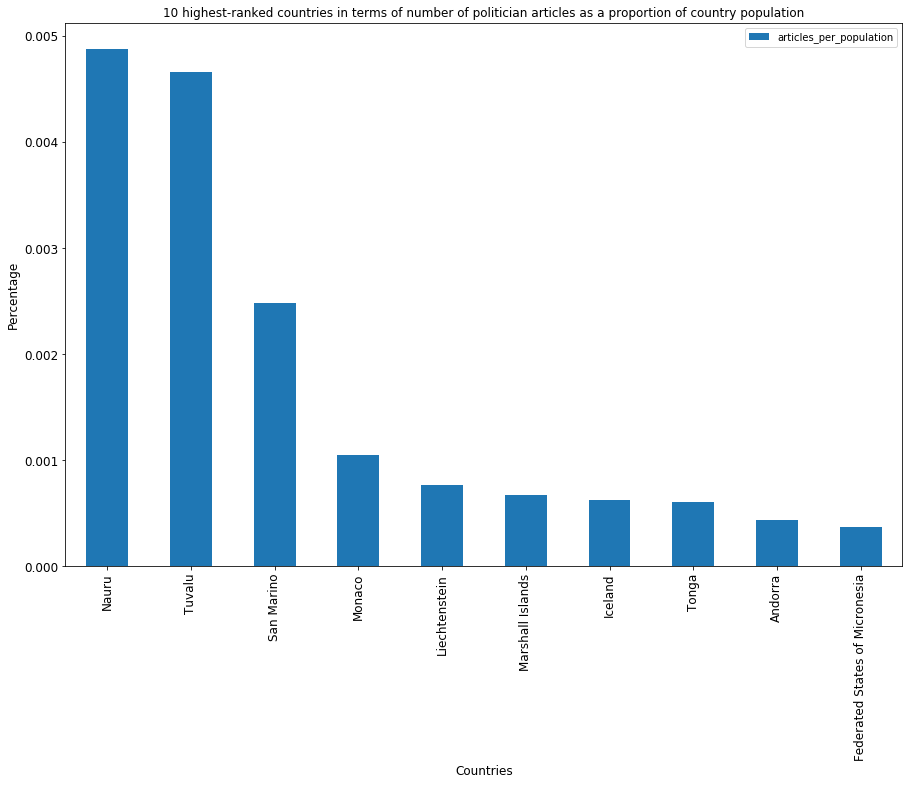

In [27]:
ax = proportion_asc[['articles_per_population']].head(10).plot(kind='bar', 
                                                      title ="10 highest-ranked countries in terms of number of politician articles as a proportion of country population", 
                                                      figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

### 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

In [35]:
proportion_desc = analysis_data.sort('articles_per_population', ascending=True)
del proportion_desc['high_quality_articles']
proportion_desc = proportion_desc.set_index('country')
proportion_desc = proportion_desc.head(10)
proportion_desc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,articles_per_population
country,
India,7.533687e-07
China,8.294944e-07
Indonesia,8.406911e-07
Uzbekistan,9.267902e-07
Ethiopia,1.069813e-06
"Korea, North",1.561062e-06
Zambia,1.680249e-06
Thailand,1.719869e-06
"Congo, Dem. Rep. of",1.936182e-06


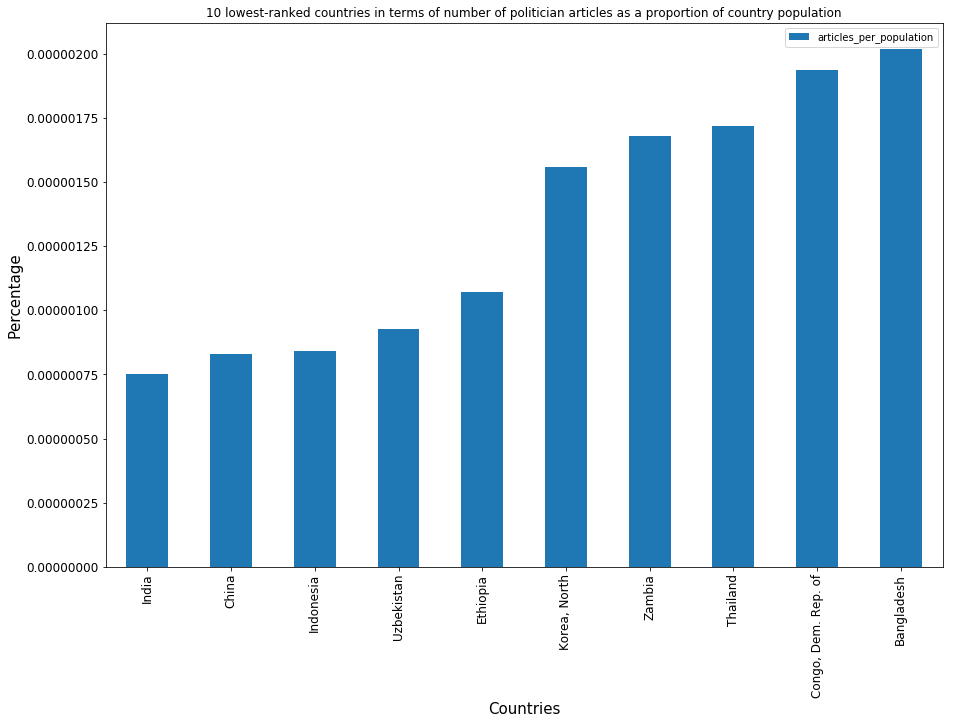

In [91]:
ax = proportion_desc[['articles_per_population']].head(10).plot(kind='bar', 
                                                      title ="10 lowest-ranked countries in terms of number of politician articles as a proportion of country population", 
                                                      figsize=(15, 10), fontsize=12)
ax.set_xlabel("Countries", fontsize=15)
ax.set_ylabel("Percentage", fontsize=15)
plt.show()

### 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [36]:
highquality_asc = analysis_data.sort('high_quality_articles', ascending=False)
del highquality_asc['articles_per_population']
highquality_asc = highquality_asc.set_index('country')
highquality_asc = highquality_asc.head(10)
highquality_asc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,high_quality_articles
country,
"Korea, North",0.230769
Romania,0.129310
Saudi Arabia,0.126050
Central African Republic,0.117647
Qatar,0.098039
Guinea-Bissau,0.095238
Vietnam,0.094241
Bhutan,0.090909
Ireland,0.081365


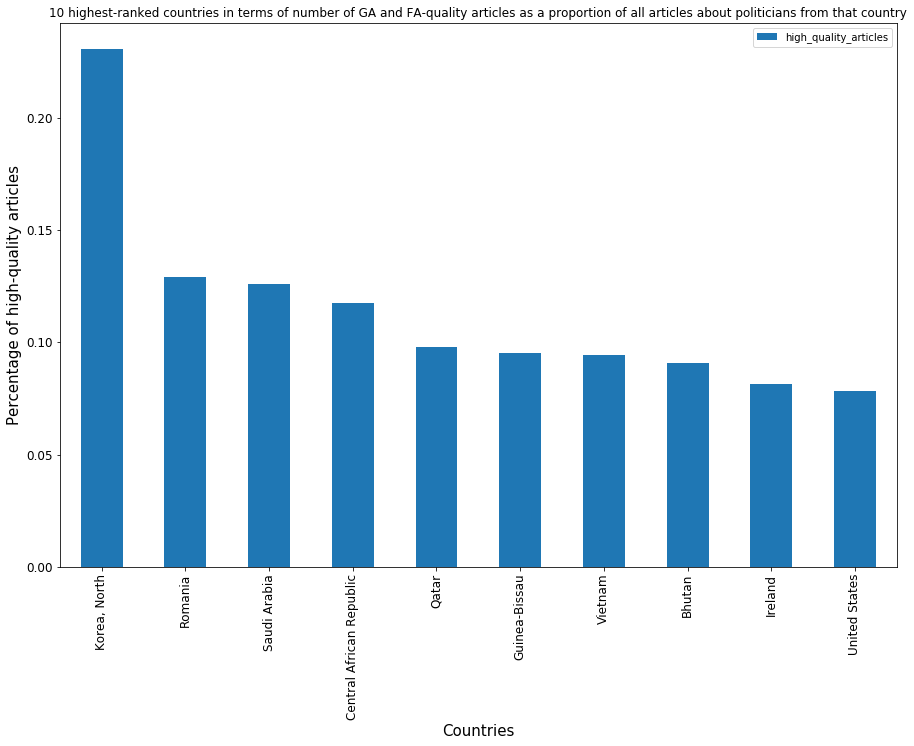

In [94]:
ax = highquality_asc[['high_quality_articles']].head(10).plot(kind='bar', 
                                                      title ="10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country", 
                                                      figsize=(15, 10), fontsize=12)
ax.set_xlabel("Countries", fontsize=15)
ax.set_ylabel("Percentage of high-quality articles", fontsize=15)
plt.show()

### 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [37]:
highquality_desc = analysis_data.sort('high_quality_articles', ascending=True)
del highquality_desc['articles_per_population']
highquality_desc = highquality_desc.set_index('country')
highquality_desc = highquality_desc.head(10)
highquality_desc

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,high_quality_articles
country,
Finland,0.001748
Tanzania,0.002451
Peru,0.002825
Czech Republic,0.003937
Lithuania,0.004032
Moldova,0.004695
Fiji,0.005025
Uganda,0.005319
Luxembourg,0.005556


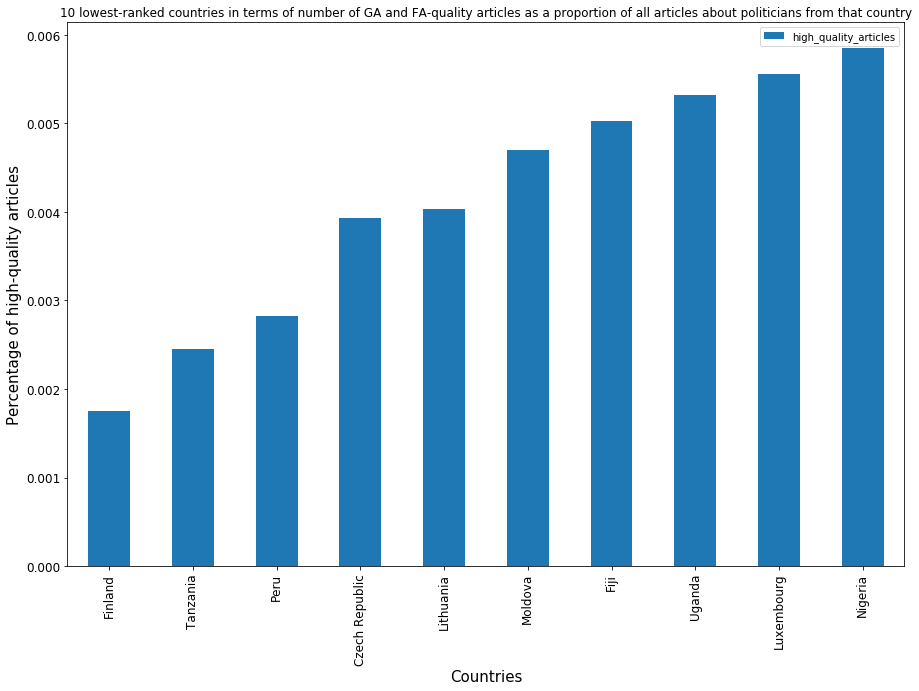

In [97]:
ax = highquality_desc[['high_quality_articles']].head(10).plot(kind='bar', 
                                                      title ="10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country", 
                                                      figsize=(15, 10), fontsize=12)
ax.set_xlabel("Countries", fontsize=15)
ax.set_ylabel("Percentage of high-quality articles", fontsize=15)
plt.show()